### Анализ оттока клиентов с помощью инструментов ML

**Задача**:

Проанализировать анкеты и данные по посещениям клиентов сети финтес-центров. Выявить проблемные группы и составить рекомендации по удержанию клиентов.

In [3]:
#Импортируем библиотеки
import pandas as pd
import numpy as np
import seaborn as sea
import itertools 
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans

In [4]:
#Увеличим максимальную длину столбцов
pd.options.display.max_colwidth = 130

### Загрузка данных

In [5]:
#Загружаем данные
try:
    gym = pd.read_csv('/datasets/gym_churn.csv') # Путь к файлам 
except:
    try:
        gym = pd.read_csv('gym_churn.csv') # Локальный путь к файлу
    except:
        gym = pd.read_csv('https://link')# Интернет ссылка на файл

In [6]:
# Отформатируем вывод для численных значений типа float
pd.set_option('display.float_format', '{:,.2f}'.format) 

In [7]:
# Посмотрим информацию о таблице 
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [8]:
#Глянем на таблицу
gym.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


In [9]:
# Выведем имена колонок
gym.columns

Index(['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone',
       'Contract_period', 'Group_visits', 'Age',
       'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime',
       'Avg_class_frequency_total', 'Avg_class_frequency_current_month',
       'Churn'],
      dtype='object')

Поменяем для удобства формат представления имён колонок

In [10]:
# Понизим кейс шрифта
gym.columns = gym.columns.str.lower()

# Выведем имена колонок
gym.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

In [11]:
# Сократим для удобства имена колонок
new_columns = { 
    'avg_additional_charges_total':'avg_add_charges_total',
    'month_to_end_contract':'month_to_end_contract',
    'avg_class_frequency_total':'avg_class_freq_total',
    'avg_class_frequency_current_month':'avg_class_freq_cur_month',
}

# Применяем метод rename для переименования столбцов
gym = gym.rename(columns=new_columns)

gym.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age', 'avg_add_charges_total',
       'month_to_end_contract', 'lifetime', 'avg_class_freq_total',
       'avg_class_freq_cur_month', 'churn'],
      dtype='object')

In [12]:
# Посмотрим на таблицу
gym.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_add_charges_total,month_to_end_contract,lifetime,avg_class_freq_total,avg_class_freq_cur_month,churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


-----------

### Проведём исследовательский анализ данных

In [13]:
#Функция выводит информацию по колонке - название, уникальные значения, количество нулей, распределение значений
def column_describe(data, column):
    print('Column:',column)
    print()
    print('Unique elements: ',data[column].unique())
    print()
    print('Zeroes count:',data[data[column] ==0][column].count())
    display(data[data[column] != data[column].isna()][[column]].describe([.001,.1,.95]).T)
    print('-'*80)
    print()

In [14]:
#Запустим функцию для таблицы gym
for col in gym.columns:
    column_describe(gym, col)

Column: gender

Unique elements:  [1 0]

Zeroes count: 1959


,count,mean,std,min,0.1%,10%,50%,95%,max
gender,"2,041.00",1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00


--------------------------------------------------------------------------------

Column: near_location

Unique elements:  [1 0]

Zeroes count: 619


,count,mean,std,min,0.1%,10%,50%,95%,max
near_location,"3,381.00",1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00


--------------------------------------------------------------------------------

Column: partner

Unique elements:  [1 0]

Zeroes count: 2053


,count,mean,std,min,0.1%,10%,50%,95%,max
partner,"1,947.00",1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00


--------------------------------------------------------------------------------

Column: promo_friends

Unique elements:  [1 0]

Zeroes count: 2766


,count,mean,std,min,0.1%,10%,50%,95%,max
promo_friends,"1,234.00",1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00


--------------------------------------------------------------------------------

Column: phone

Unique elements:  [0 1]

Zeroes count: 386


,count,mean,std,min,0.1%,10%,50%,95%,max
phone,"3,614.00",1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00


--------------------------------------------------------------------------------

Column: contract_period

Unique elements:  [ 6 12  1]

Zeroes count: 0


,count,mean,std,min,0.1%,10%,50%,95%,max
contract_period,"4,000.00",4.68,4.55,1.00,1.00,1.00,1.00,12.00,12.00


--------------------------------------------------------------------------------

Column: group_visits

Unique elements:  [1 0]

Zeroes count: 2351


,count,mean,std,min,0.1%,10%,50%,95%,max
group_visits,"1,649.00",1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00


--------------------------------------------------------------------------------

Column: age

Unique elements:  [29 31 28 33 26 34 32 30 23 27 35 25 36 24 21 37 22 19 20 38 39 18 41]

Zeroes count: 0


,count,mean,std,min,0.1%,10%,50%,95%,max
age,"4,000.00",29.18,3.26,18.00,20.00,25.00,29.00,34.00,41.00


--------------------------------------------------------------------------------

Column: avg_add_charges_total

Unique elements:  [ 14.22747042 113.20293765 129.44847933 ...  78.25054157  61.91265691
 178.86181361]

Zeroes count: 0


,count,mean,std,min,0.1%,10%,50%,95%,max
avg_add_charges_total,"4,000.00",146.94,96.36,0.15,0.36,27.29,136.22,323.44,552.59


--------------------------------------------------------------------------------

Column: month_to_end_contract

Unique elements:  [ 5. 12.  1.  6.  3. 10. 11.  9.  4.  7.  8.  2.]

Zeroes count: 0


,count,mean,std,min,0.1%,10%,50%,95%,max
month_to_end_contract,"4,000.00",4.32,4.19,1.00,1.00,1.00,1.00,12.00,12.00


--------------------------------------------------------------------------------

Column: lifetime

Unique elements:  [ 3  7  2  0  1 11  4  8 14  6  5 15 12 21 10 20  9 13 17 16 24 22 31 26
 23 18 19 27 29]

Zeroes count: 487


,count,mean,std,min,0.1%,10%,50%,95%,max
lifetime,"3,513.00",4.24,3.72,1.00,1.00,1.00,3.00,12.00,31.00


--------------------------------------------------------------------------------

Column: avg_class_freq_total

Unique elements:  [0.02039795 1.92293606 1.85909835 ... 2.78614636 1.63010814 1.10183221]

Zeroes count: 88


,count,mean,std,min,0.1%,10%,50%,95%,max
avg_class_freq_total,"3,912.00",1.92,0.94,0.00,0.01,0.70,1.86,3.56,6.02


--------------------------------------------------------------------------------

Column: avg_class_freq_cur_month

Unique elements:  [0.         1.91024352 1.73650189 ... 2.8314395  1.59623664 1.03526976]

Zeroes count: 181


,count,mean,std,min,0.1%,10%,50%,95%,max
avg_class_freq_cur_month,"3,819.00",1.85,1.00,0.00,0.01,0.56,1.78,3.58,6.15


--------------------------------------------------------------------------------

Column: churn

Unique elements:  [0 1]

Zeroes count: 2939


,count,mean,std,min,0.1%,10%,50%,95%,max
churn,"1,061.00",1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00


--------------------------------------------------------------------------------



Сгруппируем данные по признаку оттока и посмотрим что вышло

In [15]:
#Группируем таблицу по признаку оттока
gym_group = gym.groupby('churn').mean()
gym_group.style.background_gradient('coolwarm')

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_add_charges_total,month_to_end_contract,lifetime,avg_class_freq_total,avg_class_freq_cur_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Группировка по средним значениям указывает на то, что у тех, кто ушёл, усреднённые параметры ниже, чем у тех, кто остался.

### Поглядим на распределения признаков

In [16]:
#Функция подбирающая число корзин для гистограммы
def beans(data,col):
    if (data[col].max() > 500): 
        return 30
    elif (data[col].max() <= 100):
        return  12
    else: return 20

In [17]:
#Функция для автоматического построения гистограмм и ящиков с усами без фильтрации выбросов
def hist_plot(data,col, mark='', mark2='',cluster=''):
    display(data[[col]].describe([.001,.1,.95]).T)
    box_n_c = data.query('churn == 0')[col][data[col].notnull()]
    box_c = data.query('churn == 1')[col][data[col].notnull()]
    box_data = [box_n_c,box_c]
    box_labels = ['Not churn','Churn']
    plt.boxplot(box_data,labels=box_labels,vert=False)
    plt.title(''+col)
    plt.xlabel('Значения ' + cluster)
    plt.show() 
    print('bins = ', beans(data,col))
    hp = data.query('churn == 0')[col]\
.plot.hist(bins=beans(data,col), grid=True,title='Распределение ' + col + ' ' + cluster, figsize=(12,5),label='not churn')
    hp_c = data.query('churn == 1')[col]\
.plot.hist(bins=beans(data,col), grid=True,title='Распределение ' + col + ' ' + cluster, figsize=(12,5),label='churn')
    hp.set_xlabel('Значения ' + col + ' ' + cluster)
    hp.set_ylabel('Количество клиентов')
    plt.legend()
    plt.show()

,count,mean,std,min,0.1%,10%,50%,95%,max
contract_period,"4,000.00",4.68,4.55,1.00,1.00,1.00,1.00,12.00,12.00


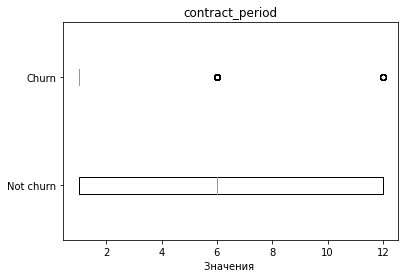

bins =  12


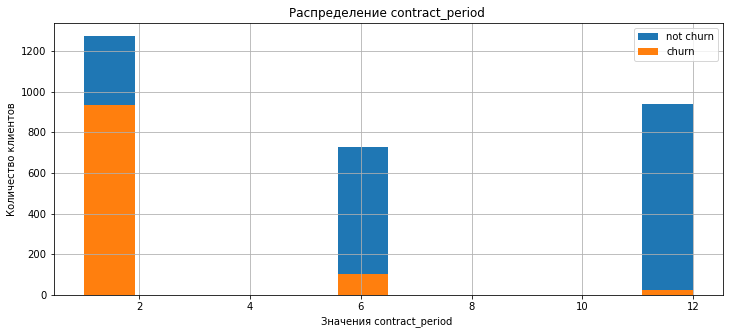

,count,mean,std,min,0.1%,10%,50%,95%,max
age,"4,000.00",29.18,3.26,18.00,20.00,25.00,29.00,34.00,41.00


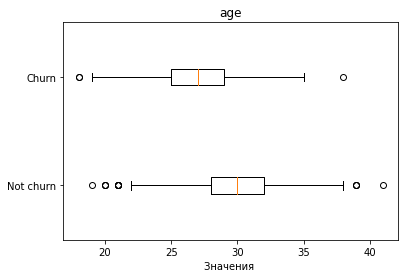

bins =  12


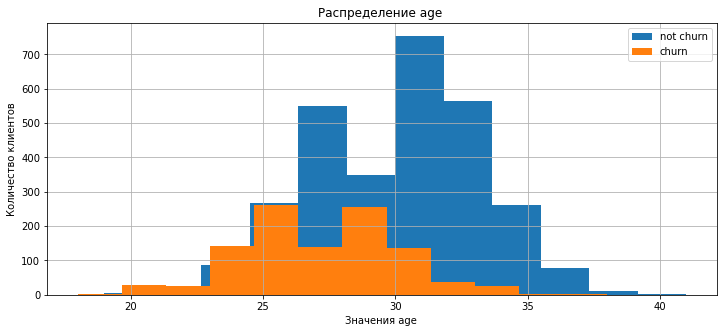

,count,mean,std,min,0.1%,10%,50%,95%,max
avg_add_charges_total,"4,000.00",146.94,96.36,0.15,0.36,27.29,136.22,323.44,552.59


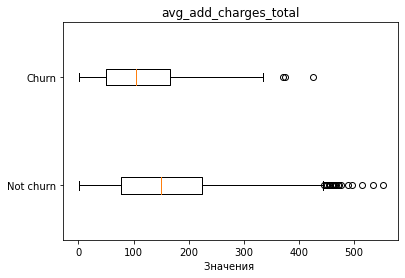

bins =  30


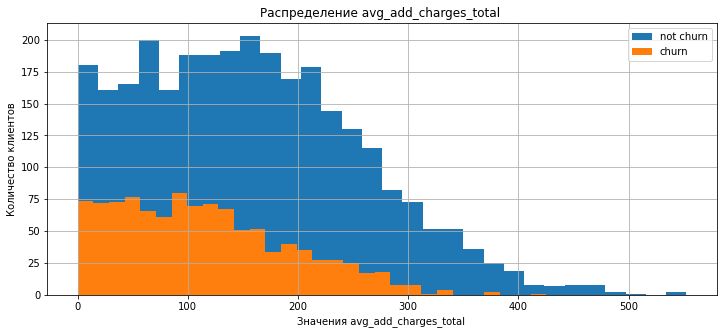

,count,mean,std,min,0.1%,10%,50%,95%,max
month_to_end_contract,"4,000.00",4.32,4.19,1.00,1.00,1.00,1.00,12.00,12.00


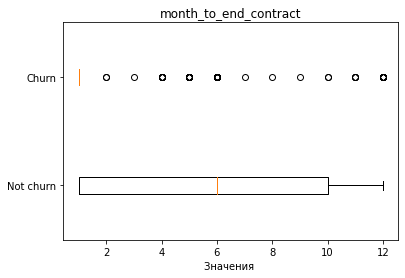

bins =  12


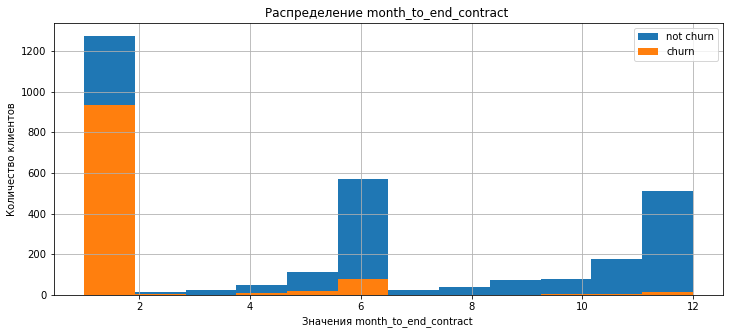

,count,mean,std,min,0.1%,10%,50%,95%,max
lifetime,"4,000.00",3.72,3.75,0.00,0.00,0.00,3.00,11.00,31.00


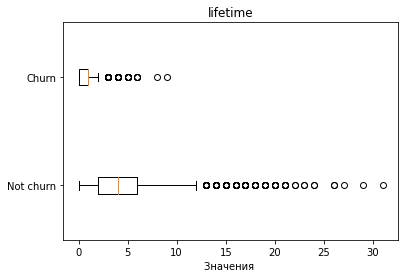

bins =  12


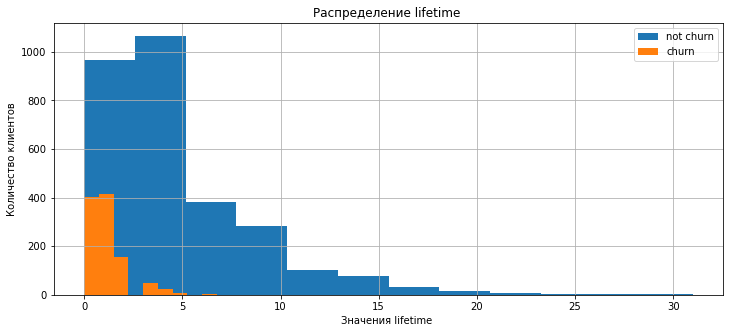

,count,mean,std,min,0.1%,10%,50%,95%,max
avg_class_freq_total,"4,000.00",1.88,0.97,0.00,0.00,0.61,1.83,3.54,6.02


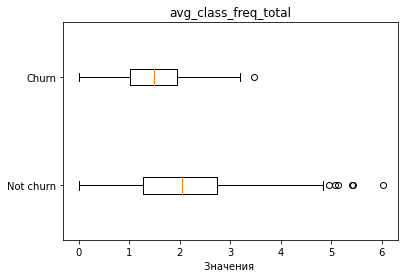

bins =  12


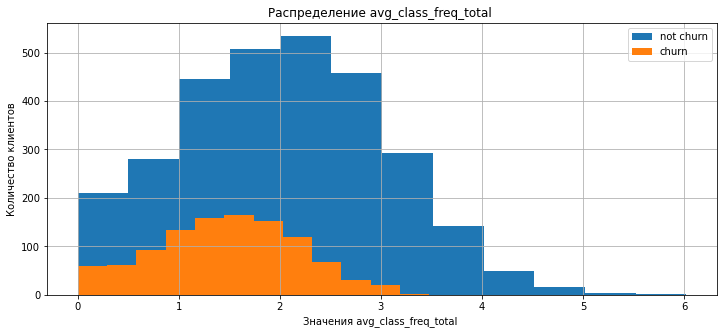

,count,mean,std,min,0.1%,10%,50%,95%,max
avg_class_freq_cur_month,"4,000.00",1.77,1.05,0.00,0.00,0.35,1.72,3.55,6.15


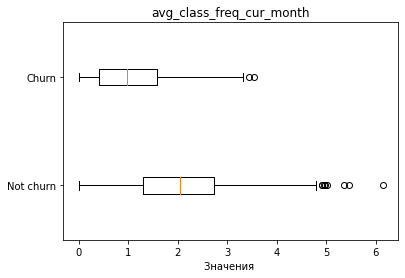

bins =  12


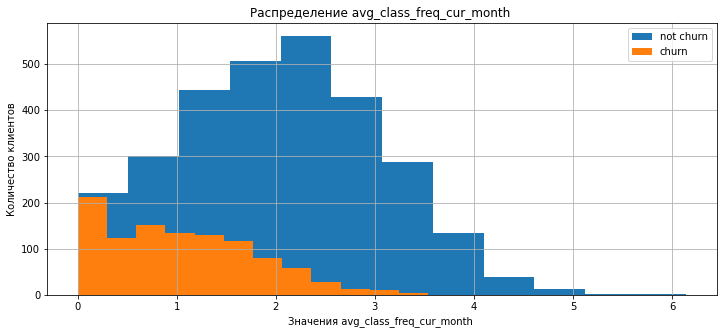

In [18]:
#Нарисуем графики распределения значений по интересующим нас колонкам 
for col in ['contract_period',
            'age','avg_add_charges_total',
            'month_to_end_contract',
            'lifetime','avg_class_freq_total',
       'avg_class_freq_cur_month']:
    hist_plot(gym,col,'not churn', 'churn')

In [19]:
# Построим матрицу корреляций
gym.corr().style.background_gradient('coolwarm')

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_add_charges_total,month_to_end_contract,lifetime,avg_class_freq_total,avg_class_freq_cur_month,churn
gender,1.000000,0.006699,-0.010463,-0.005033,-0.008542,0.000502,0.017879,0.013807,-0.009334,-0.001281,0.013579,0.014620,0.009156,0.000708
near_location,0.006699,1.000000,-0.005119,0.210964,-0.015763,0.150233,0.154728,0.058358,0.040761,0.143961,0.070921,0.043127,0.062664,-0.128098
partner,-0.010463,-0.005119,1.000000,0.451960,0.009970,0.306166,0.022710,0.047480,0.022941,0.294632,0.061229,0.024938,0.045561,-0.157986
promo_friends,-0.005033,0.210964,0.451960,1.000000,0.001982,0.244552,0.120170,0.050113,0.036898,0.239553,0.072721,0.028063,0.053768,-0.162233
phone,-0.008542,-0.015763,0.009970,0.001982,1.000000,-0.006893,-0.010099,-0.011403,0.009279,-0.011196,-0.018801,0.008340,0.013375,-0.001177
contract_period,0.000502,0.150233,0.306166,0.244552,-0.006893,1.000000,0.169991,0.138249,0.111445,0.973064,0.170725,0.096211,0.159407,-0.389984
group_visits,0.017879,0.154728,0.022710,0.120170,-0.010099,0.169991,1.000000,0.080934,0.032079,0.163703,0.075853,0.056695,0.075923,-0.175325
age,0.013807,0.058358,0.047480,0.050113,-0.011403,0.138249,0.080934,1.000000,0.080240,0.134511,0.164693,0.119953,0.183095,-0.404735
avg_add_charges_total,-0.009334,0.040761,0.022941,0.036898,0.009279,0.111445,0.032079,0.080240,1.000000,0.113958,0.079028,0.044426,0.079570,-0.198697
month_to_end_contract,-0.001281,0.143961,0.294632,0.239553,-0.011196,0.973064,0.163703,0.134511,0.113958,1.000000,0.161078,0.085387,0.147605,-0.381393


**Выводы**

Явных пропусков нет. Хорошо бы знать кто получил абонемент в подарок, а кто купил сам. Промо - подобный признак, но всё таки по промо клиенты скорей всего платят сами. 

Между собой сильно коррелируют параметры общего и оставшегося срока контракта а также частота посещений общая и за последний месяц.
Самыми важными признаками являются продолжительность контракта, время до прекращения контракта, лайфтайм и частота посещений. Чем дольше и чаще клиент ходит в зал, тем реже он бросает тренировки.

### Построим модель прогнозирования оттока клиентов

In [20]:
# Разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = gym.drop(columns=['churn'])
y = gym['churn']

In [21]:
# Разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)

In [22]:
# Зададим список моделей
models = [
    LogisticRegression(solver='liblinear'),
    RandomForestClassifier()
   ]

In [23]:
# Функция, которая принимает на вход модель и данные и выводит метрики
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print('- '*50)  

In [24]:
# Цикл, который выводит метрики по списку моделей
for i in models:
    print(i)
    make_prediction(i, X_train, y_train, X_test, y_test)

LogisticRegression(solver='liblinear')
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       602
           1       0.86      0.83      0.85       198

    accuracy                           0.93       800
   macro avg       0.90      0.89      0.90       800
weighted avg       0.92      0.93      0.92       800

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
RandomForestClassifier()
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       602
           1       0.85      0.79      0.82       198

    accuracy                           0.91       800
   macro avg       0.89      0.87      0.88       800
weighted avg       0.91      0.91      0.91       800

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


**Выводы**

Логистическая регрессия оказалась лучше случайного леса по всем метрикам.

------

### Проведём кластеризацию клиентов

In [25]:
# Стандартизируем данные
sc = StandardScaler()
x_sc = sc.fit_transform(X)

Построим дендрограмму признаков.

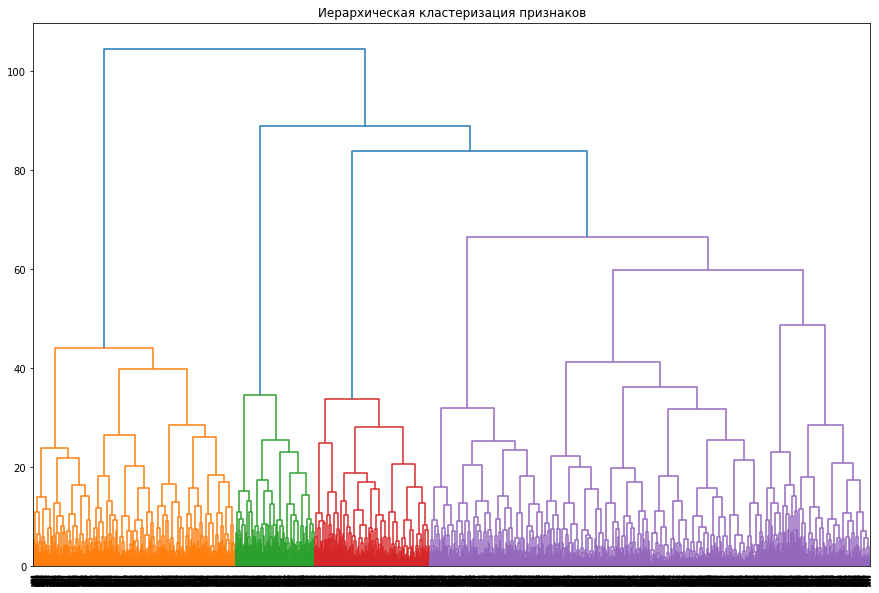

CPU times: user 1min 22s, sys: 3.89 s, total: 1min 26s
Wall time: 1min 26s


In [26]:
%%time
# Рисуем дендрограмму
linked = linkage(x_sc, method = 'ward') 
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация признаков')
plt.show() 

На основании полученного графика можем выделить 4 основных кластера. По условиям задачи число кластеров при использовании алгортима K-means необходимо установить равным 5. Так и поступим.

In [27]:
# Задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)

# Прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels = km.fit_predict(x_sc)

# Cохраняем метки кластера в поле нашего датасета
gym['cluster_km'] = labels

# Выводим статистику по средним значениям наших признаков по кластеру
display(gym.groupby('cluster_km').mean().style.background_gradient('coolwarm'))

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_add_charges_total,month_to_end_contract,lifetime,avg_class_freq_total,avg_class_freq_cur_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
1,0.480787,0.812559,0.000000,0.086223,1.000000,1.866917,0.325211,28.145267,131.369042,1.791003,2.345829,1.325865,1.086883,0.550141
2,0.559567,0.858002,0.338147,0.197353,0.998797,2.730445,0.448857,30.196149,164.579011,2.519856,5.010830,2.928140,2.934140,0.048135
3,0.509603,0.750320,1.000000,0.451985,1.000000,2.554417,0.303457,28.499360,129.812508,2.370038,2.832266,1.355379,1.176172,0.395647
4,0.495726,0.943376,0.752137,0.541667,1.000000,11.352564,0.564103,29.993590,164.563799,10.376068,4.817308,2.028169,2.020129,0.023504


**Выводы**

Судя по средним значениям признаков для кластеров самая высокая вероятность оттока у кластеров "1" и "3". Средние признаки для них имеют самые низкие значения среди других, это и самое маленькое время до окончания контракта, и самое маленькое время контракта, самый низкий средний возраст, также они реже всего посещают тренировки и дальше всех живут от зала. 

------------------

Посмотрим на распределение признаков внутри каждого кластера.

----------------------------------------------------------------------------------------------------
Cluster 0


,count,mean,std,min,0.1%,10%,50%,95%,max
contract_period,385.00,4.79,4.54,1.00,1.00,1.00,1.00,12.00,12.00


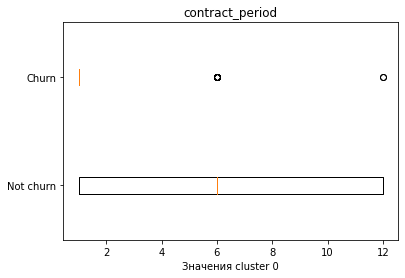

bins =  12


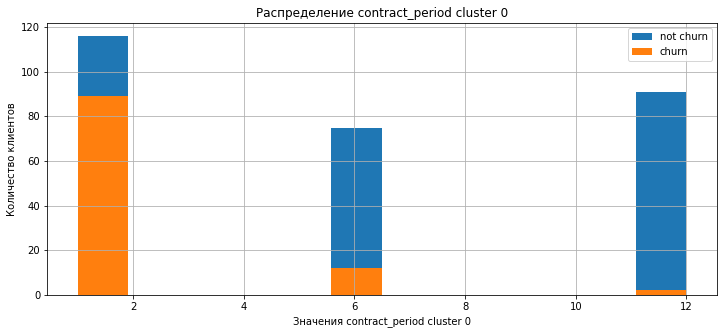

,count,mean,std,min,0.1%,10%,50%,95%,max
age,385.00,29.30,3.16,20.00,20.38,25.00,29.00,35.00,38.00


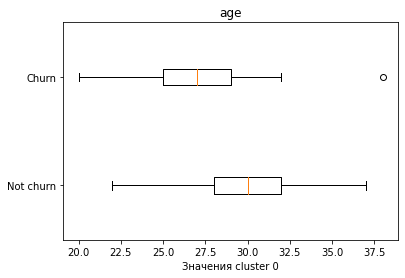

bins =  12


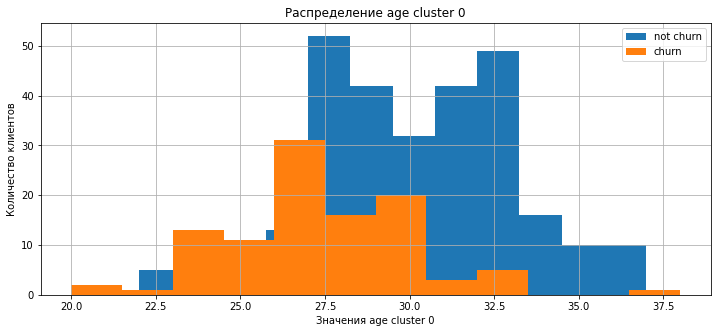

,count,mean,std,min,0.1%,10%,50%,95%,max
avg_add_charges_total,385.00,143.96,94.12,1.77,1.93,24.71,136.92,311.31,496.17


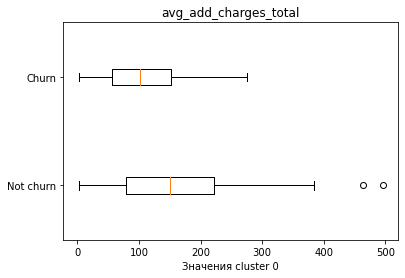

bins =  20


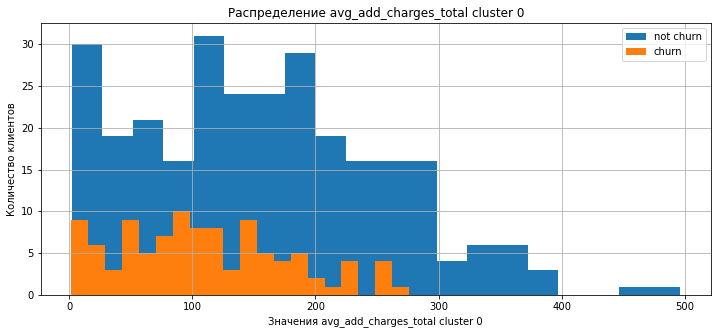

,count,mean,std,min,0.1%,10%,50%,95%,max
month_to_end_contract,385.00,4.48,4.25,1.00,1.00,1.00,1.00,12.00,12.00


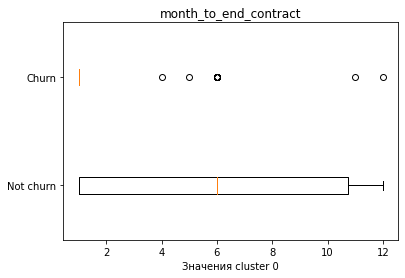

bins =  12


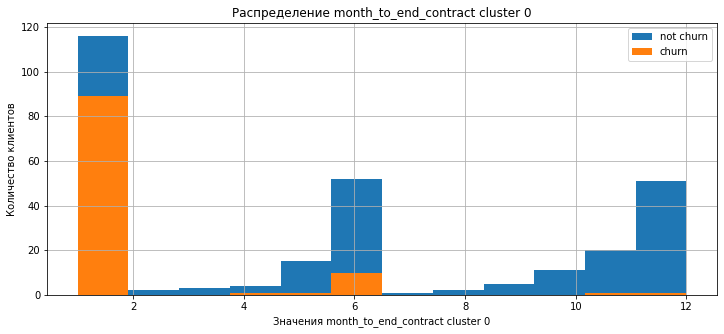

,count,mean,std,min,0.1%,10%,50%,95%,max
lifetime,385.00,3.92,4.05,0.00,0.00,0.00,3.00,12.00,26.00


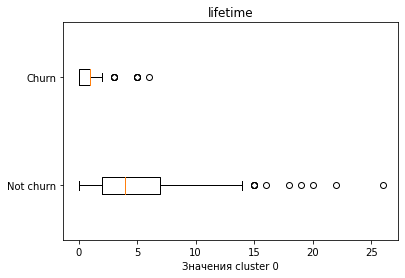

bins =  12


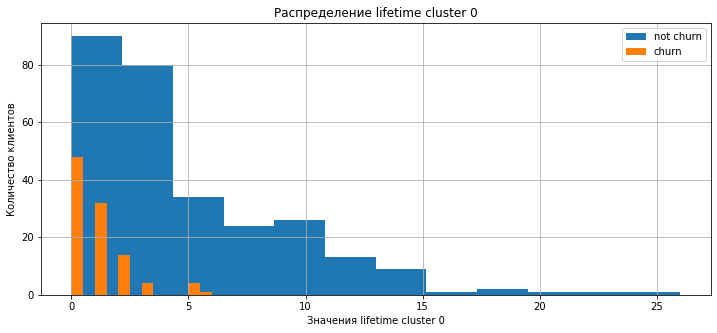

,count,mean,std,min,0.1%,10%,50%,95%,max
avg_class_freq_total,385.00,1.85,0.93,0.00,0.00,0.73,1.82,3.49,4.79


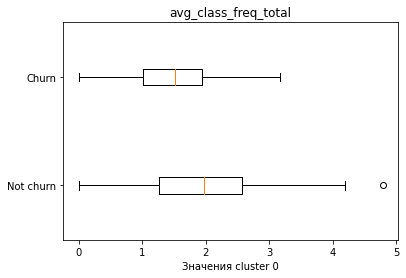

bins =  12


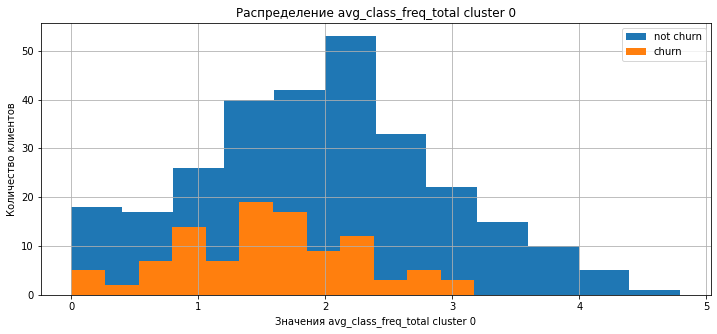

,count,mean,std,min,0.1%,10%,50%,95%,max
avg_class_freq_cur_month,385.00,1.72,1.01,0.00,0.00,0.34,1.65,3.51,4.73


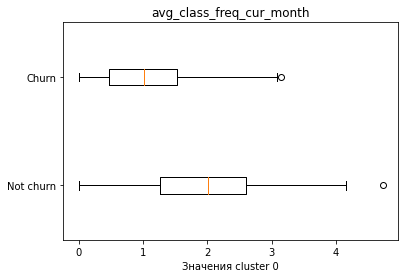

bins =  12


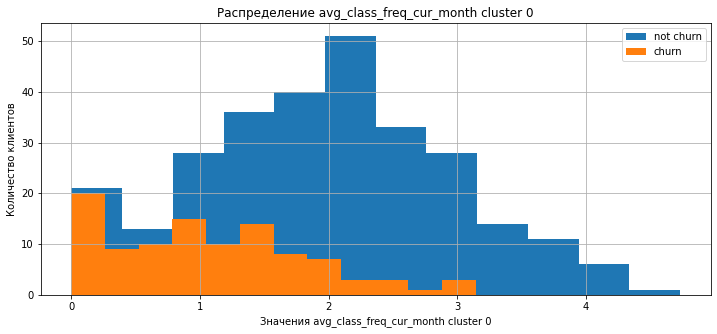

----------------------------------------------------------------------------------------------------
Cluster 1


,count,mean,std,min,0.1%,10%,50%,95%,max
contract_period,"1,067.00",1.87,2.05,1.00,1.00,1.00,1.00,6.00,12.00


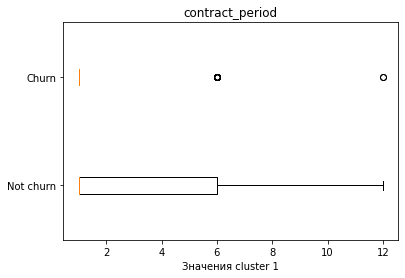

bins =  12


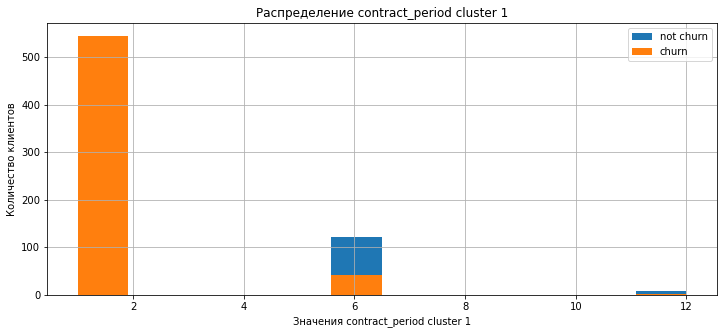

,count,mean,std,min,0.1%,10%,50%,95%,max
age,"1,067.00",28.15,3.26,18.00,19.00,24.00,28.00,33.00,41.00


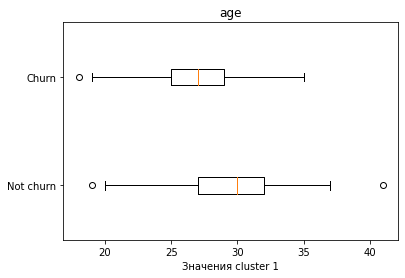

bins =  12


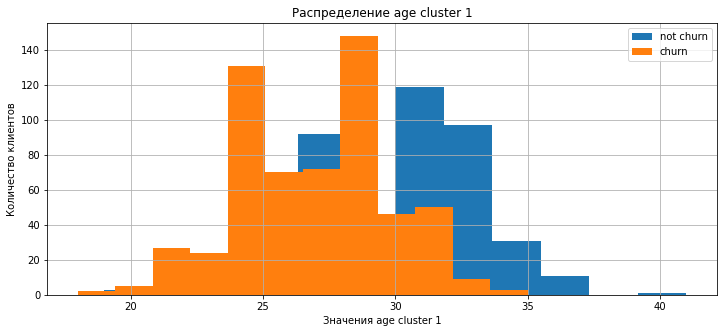

,count,mean,std,min,0.1%,10%,50%,95%,max
avg_add_charges_total,"1,067.00",131.37,87.58,0.17,0.34,25.59,120.50,292.11,515.39


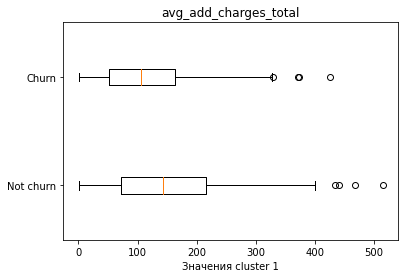

bins =  30


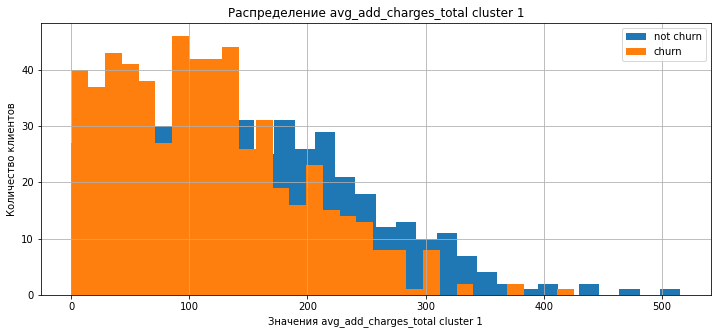

,count,mean,std,min,0.1%,10%,50%,95%,max
month_to_end_contract,"1,067.00",1.79,1.87,1.00,1.00,1.00,1.00,6.00,12.00


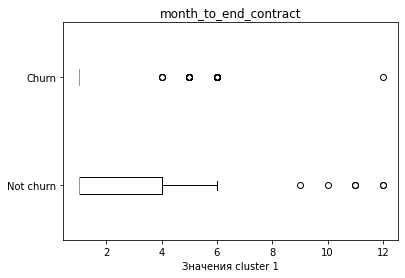

bins =  12


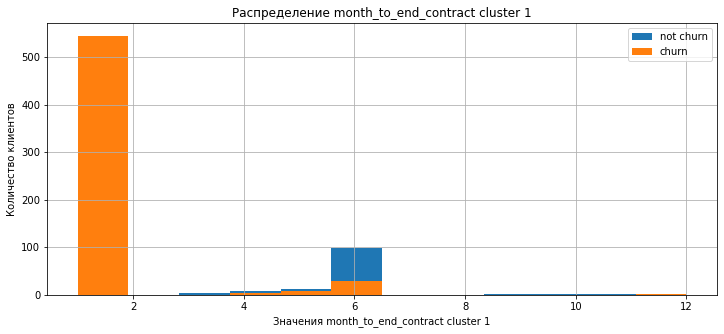

,count,mean,std,min,0.1%,10%,50%,95%,max
lifetime,"1,067.00",2.35,2.85,0.00,0.00,0.00,1.00,7.70,24.00


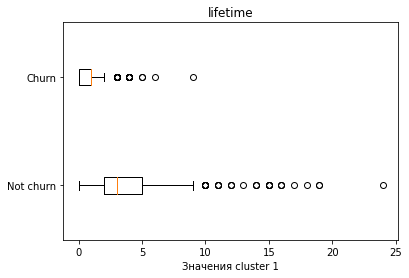

bins =  12


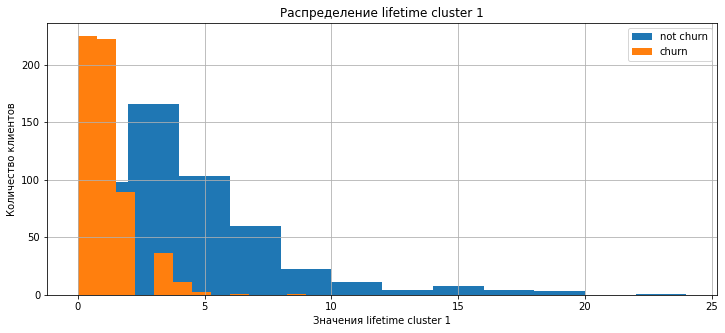

,count,mean,std,min,0.1%,10%,50%,95%,max
avg_class_freq_total,"1,067.00",1.33,0.64,0.00,0.00,0.47,1.35,2.32,3.03


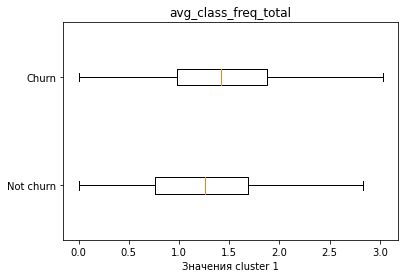

bins =  12


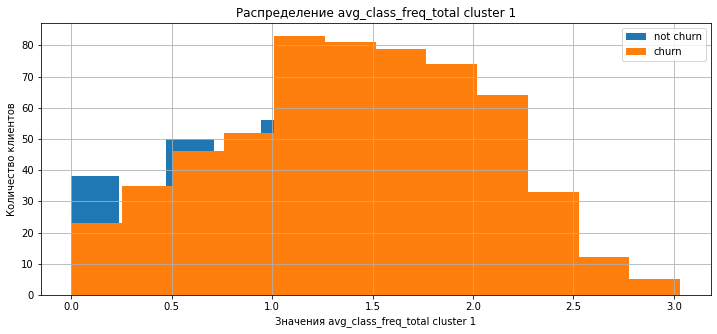

,count,mean,std,min,0.1%,10%,50%,95%,max
avg_class_freq_cur_month,"1,067.00",1.09,0.67,0.00,0.00,0.08,1.10,2.20,2.81


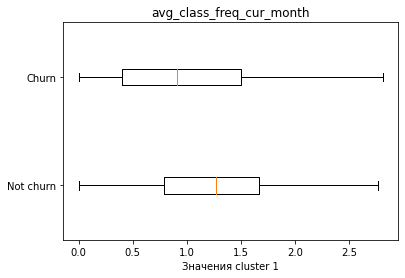

bins =  12


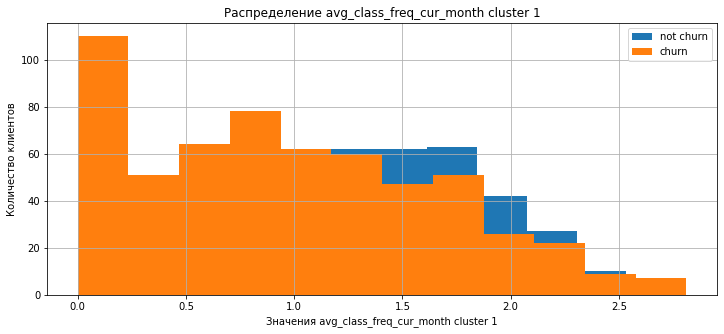

----------------------------------------------------------------------------------------------------
Cluster 2


,count,mean,std,min,0.1%,10%,50%,95%,max
contract_period,831.00,2.73,2.66,1.00,1.00,1.00,1.00,6.00,12.00


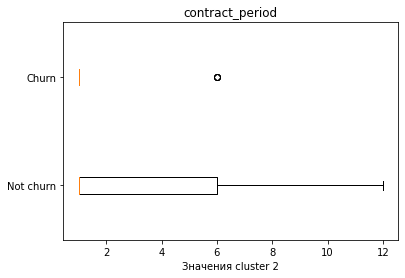

bins =  12


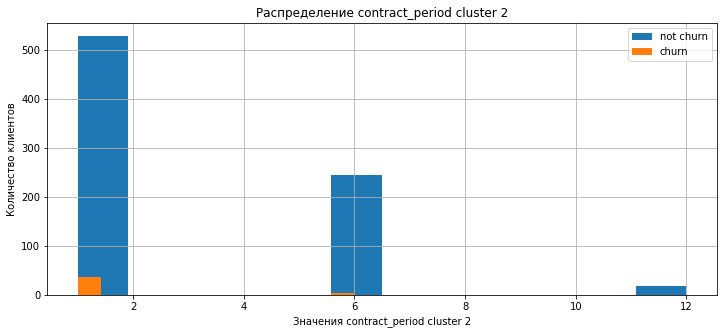

,count,mean,std,min,0.1%,10%,50%,95%,max
age,831.00,30.20,3.02,21.00,21.00,26.00,30.00,35.00,39.00


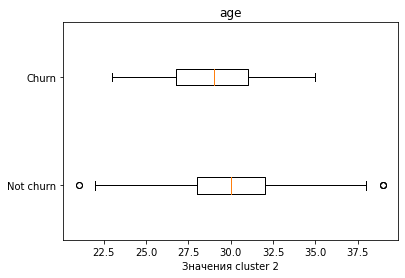

bins =  12


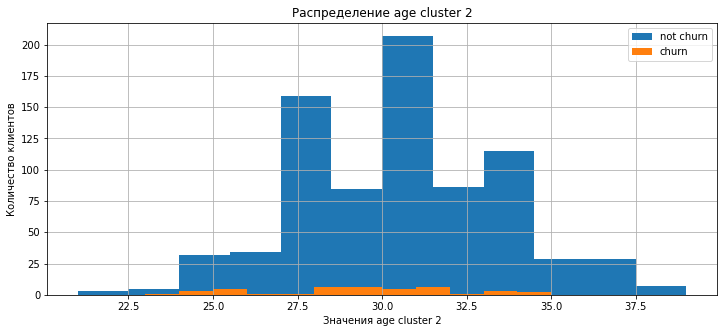

,count,mean,std,min,0.1%,10%,50%,95%,max
avg_add_charges_total,831.00,164.58,104.16,0.36,0.49,33.95,153.97,347.43,534.26


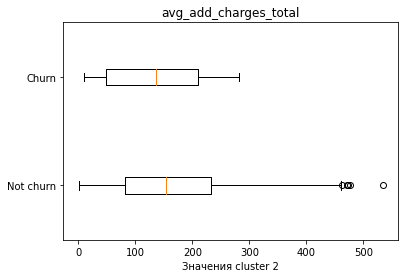

bins =  30


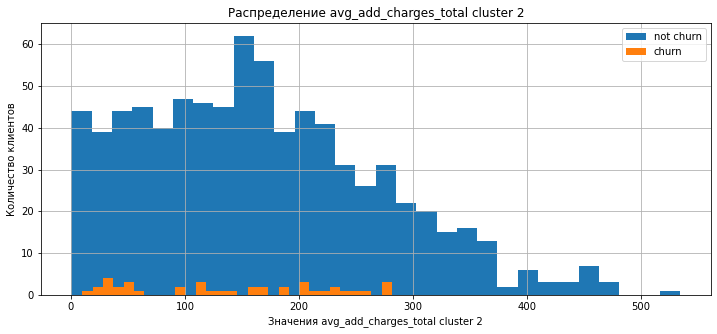

,count,mean,std,min,0.1%,10%,50%,95%,max
month_to_end_contract,831.00,2.52,2.31,1.00,1.00,1.00,1.00,6.00,12.00


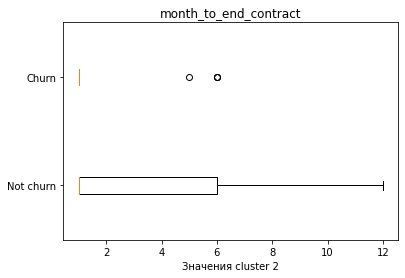

bins =  12


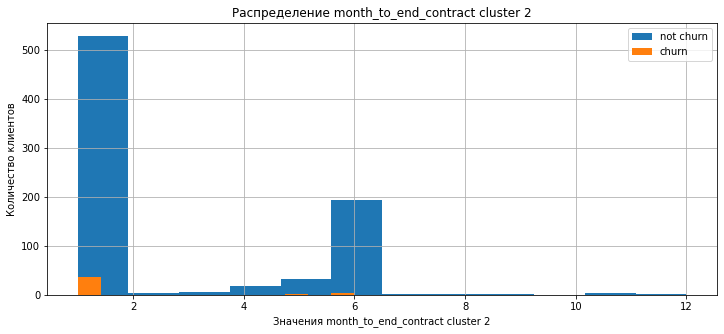

,count,mean,std,min,0.1%,10%,50%,95%,max
lifetime,831.00,5.01,4.17,0.00,0.00,1.00,4.00,13.50,29.00


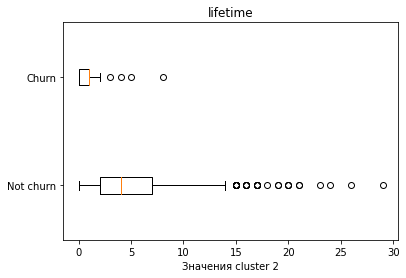

bins =  12


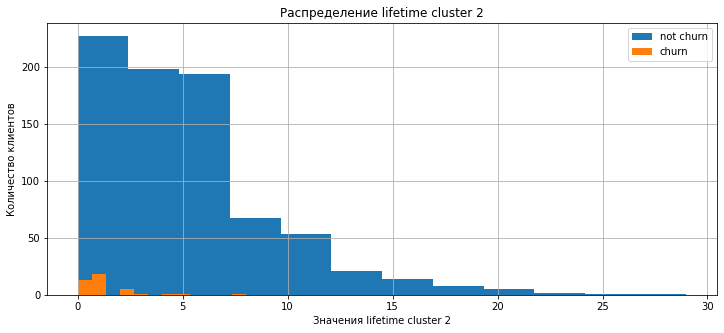

,count,mean,std,min,0.1%,10%,50%,95%,max
avg_class_freq_total,831.00,2.93,0.65,1.39,1.47,2.20,2.85,4.09,6.02


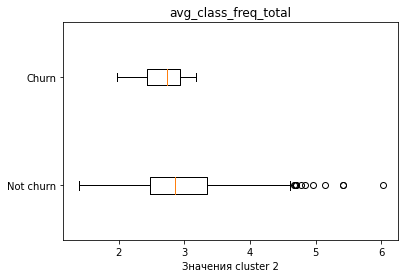

bins =  12


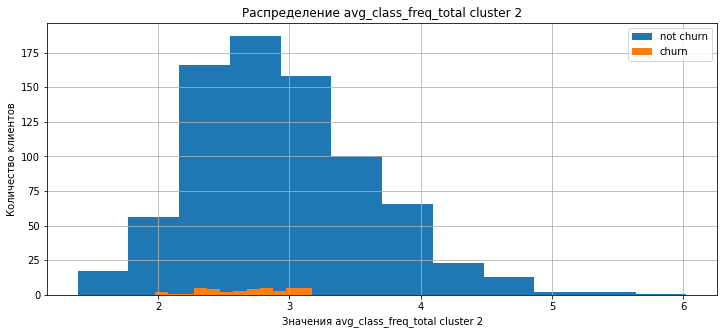

,count,mean,std,min,0.1%,10%,50%,95%,max
avg_class_freq_cur_month,831.00,2.93,0.66,1.38,1.50,2.20,2.87,4.11,6.15


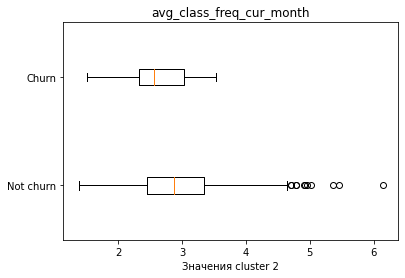

bins =  12


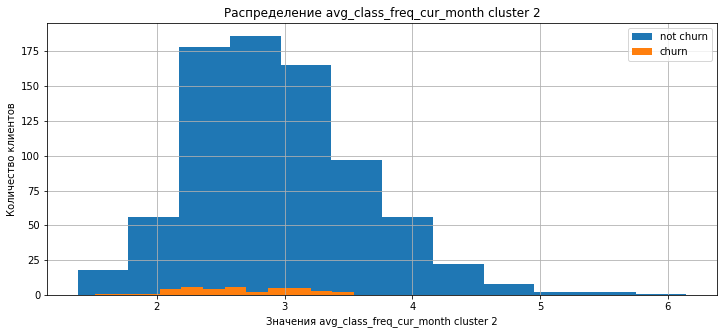

----------------------------------------------------------------------------------------------------
Cluster 3


,count,mean,std,min,0.1%,10%,50%,95%,max
contract_period,781.00,2.55,2.39,1.00,1.00,1.00,1.00,6.00,12.00


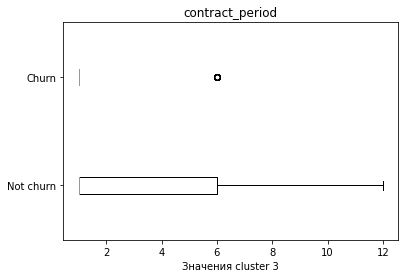

bins =  12


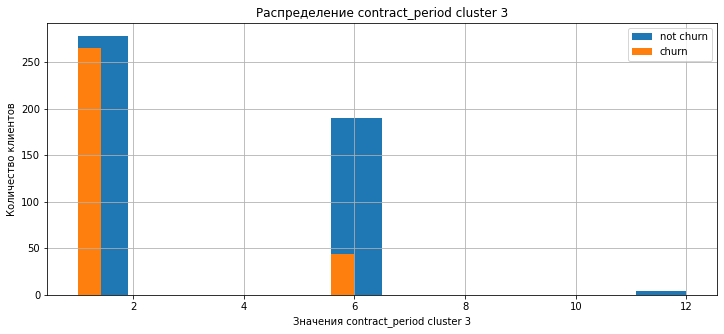

,count,mean,std,min,0.1%,10%,50%,95%,max
age,781.00,28.50,3.16,18.00,19.56,24.00,29.00,33.00,37.00


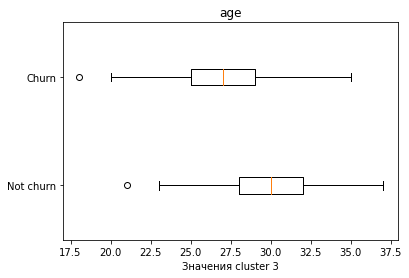

bins =  12


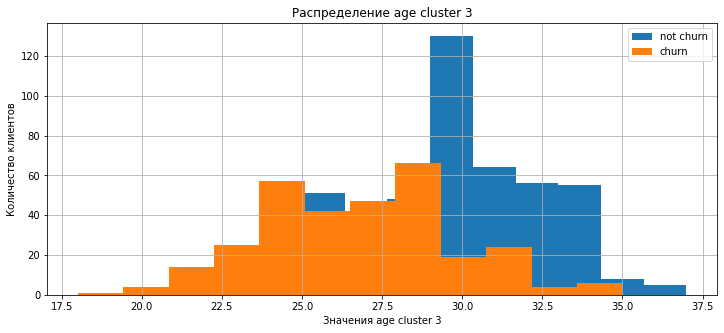

,count,mean,std,min,0.1%,10%,50%,95%,max
avg_add_charges_total,781.00,129.81,87.68,0.15,1.07,21.39,117.49,291.30,412.61


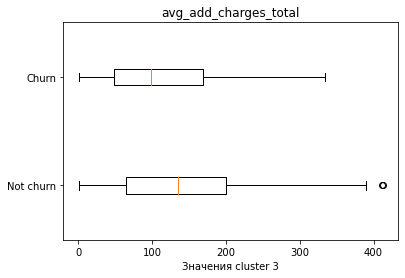

bins =  20


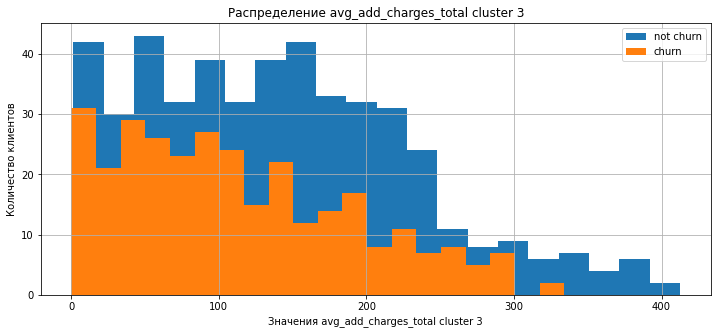

,count,mean,std,min,0.1%,10%,50%,95%,max
month_to_end_contract,781.00,2.37,2.15,1.00,1.00,1.00,1.00,6.00,12.00


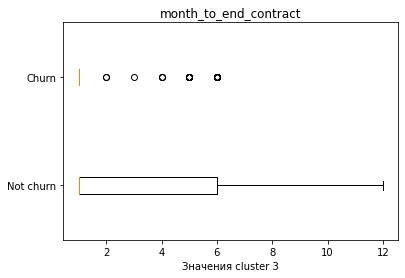

bins =  12


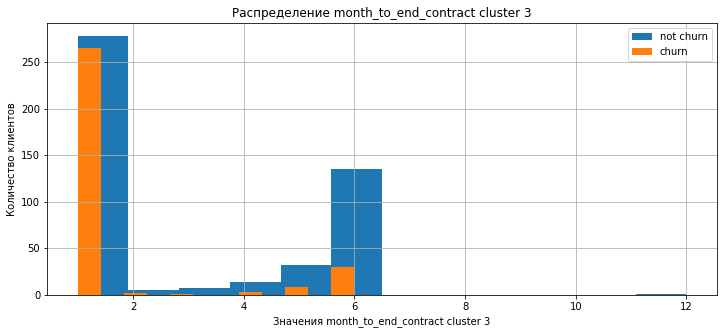

,count,mean,std,min,0.1%,10%,50%,95%,max
lifetime,781.00,2.83,2.91,0.00,0.00,0.00,2.00,9.00,22.00


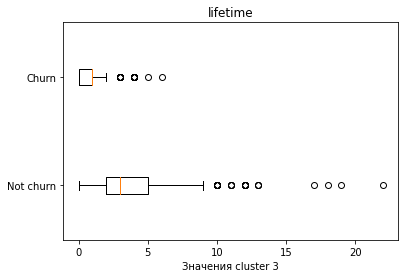

bins =  12


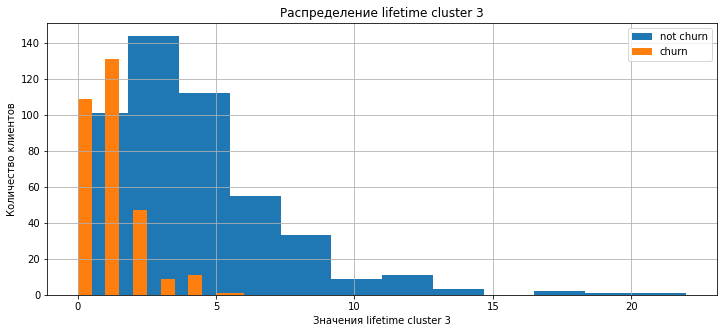

,count,mean,std,min,0.1%,10%,50%,95%,max
avg_class_freq_total,781.00,1.36,0.68,0.00,0.00,0.37,1.42,2.35,3.19


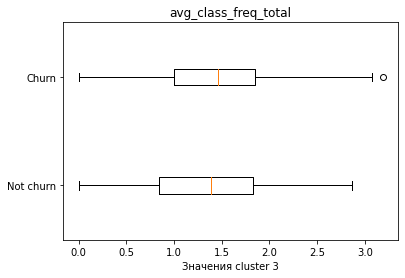

bins =  12


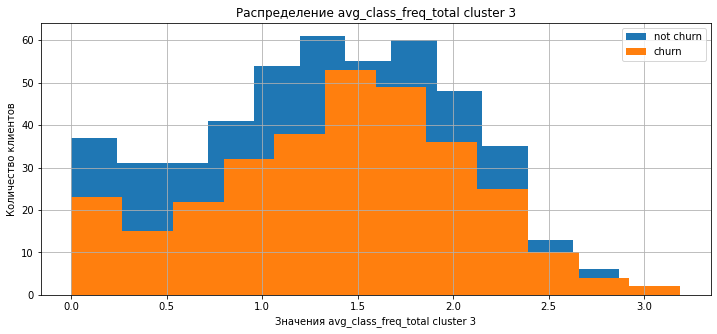

,count,mean,std,min,0.1%,10%,50%,95%,max
avg_class_freq_cur_month,781.00,1.18,0.72,0.00,0.00,0.08,1.22,2.30,2.99


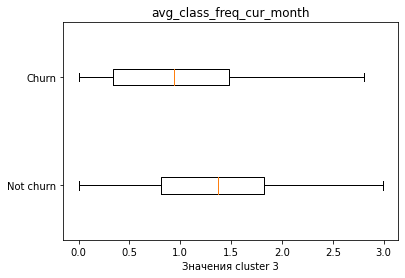

bins =  12


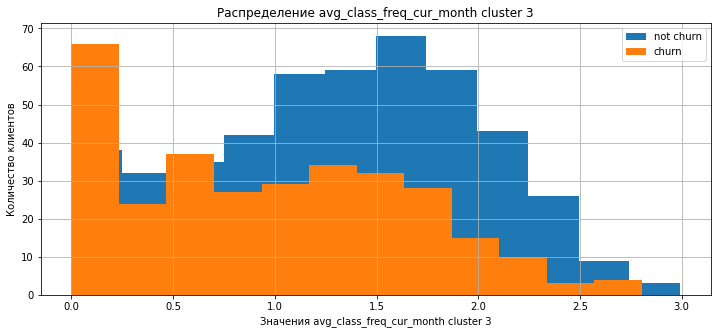

----------------------------------------------------------------------------------------------------
Cluster 4


,count,mean,std,min,0.1%,10%,50%,95%,max
contract_period,936.00,11.35,1.86,6.00,6.00,6.00,12.00,12.00,12.00


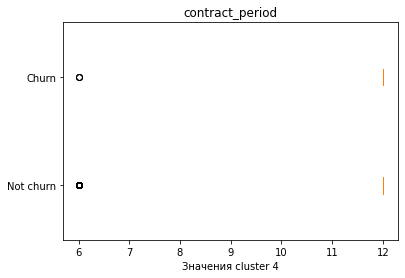

bins =  12


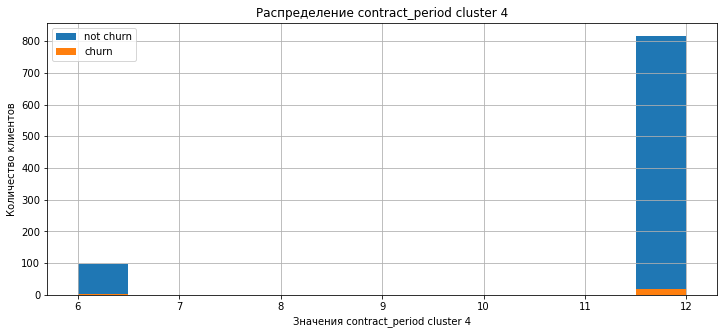

,count,mean,std,min,0.1%,10%,50%,95%,max
age,936.00,29.99,3.09,20.00,20.00,26.00,30.00,35.00,38.00


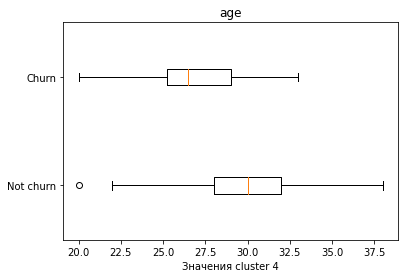

bins =  12


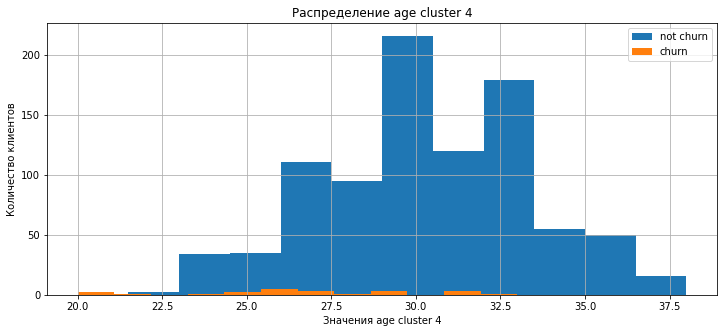

,count,mean,std,min,0.1%,10%,50%,95%,max
avg_add_charges_total,936.00,164.56,100.84,0.25,0.95,34.81,159.53,338.42,552.59


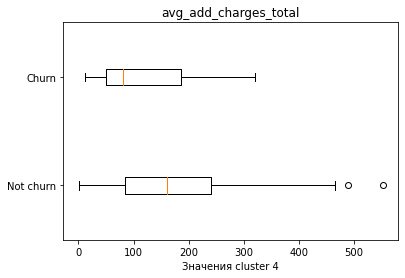

bins =  30


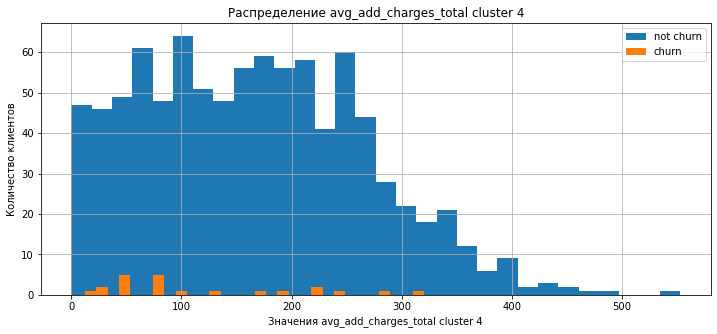

,count,mean,std,min,0.1%,10%,50%,95%,max
month_to_end_contract,936.00,10.38,2.24,2.00,2.00,6.00,11.00,12.00,12.00


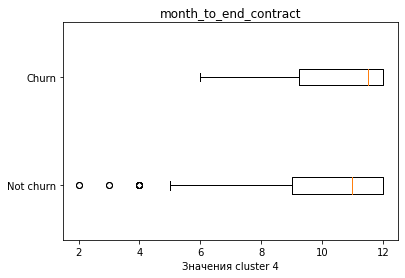

bins =  12


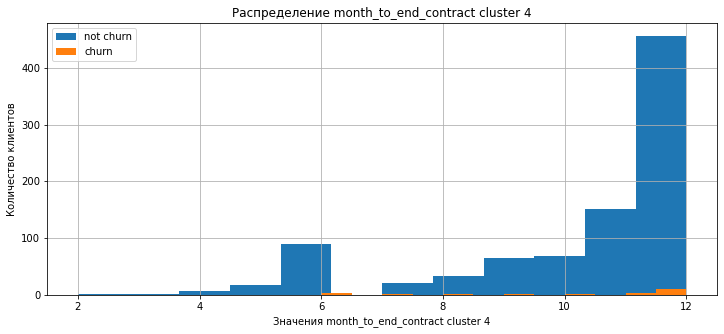

,count,mean,std,min,0.1%,10%,50%,95%,max
lifetime,936.00,4.82,4.01,0.00,0.00,1.00,4.00,13.00,31.00


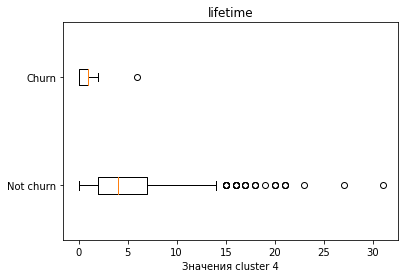

bins =  12


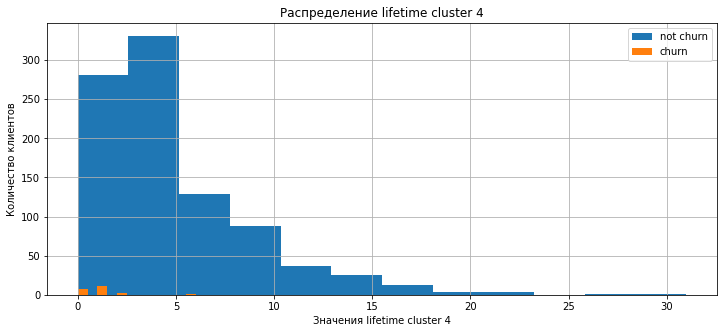

,count,mean,std,min,0.1%,10%,50%,95%,max
avg_class_freq_total,936.00,2.03,0.94,0.00,0.00,0.70,2.08,3.51,5.08


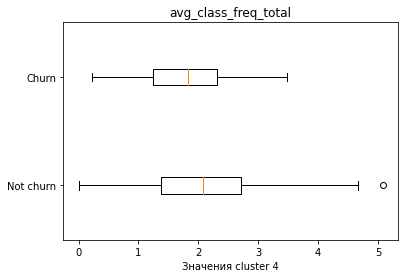

bins =  12


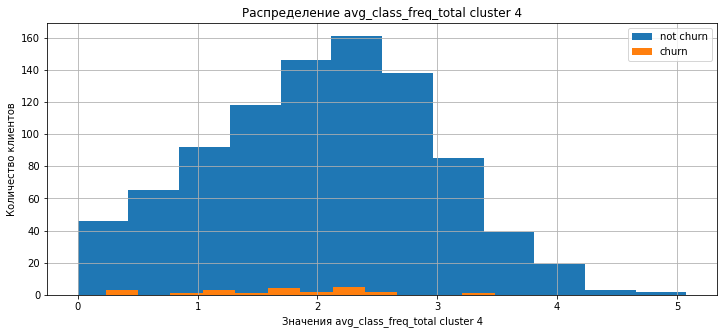

,count,mean,std,min,0.1%,10%,50%,95%,max
avg_class_freq_cur_month,936.00,2.02,0.95,0.00,0.00,0.70,2.08,3.51,4.98


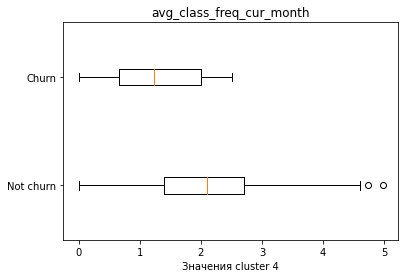

bins =  12


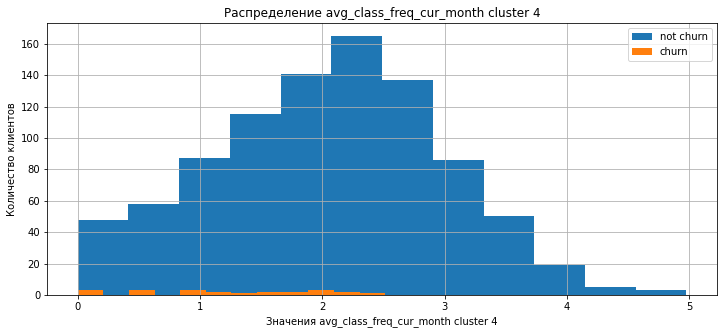

In [28]:
#Нарисуем графики распределения значений по интересующим нас колонкам с учётом кластера
for cl in sorted(gym['cluster_km'].unique()):
    print('-'*100)
    print('Cluster', cl)
    for col in ['contract_period',
                'age','avg_add_charges_total',
                'month_to_end_contract',
                'lifetime','avg_class_freq_total',
               'avg_class_freq_cur_month']:
        hist_plot(gym.query('cluster_km == @cl'),col,'not churn', 'churn', 'cluster ' + str(cl))

In [29]:
#Посмотрим на наши кластеры в реальных цифрах
gym_churn = gym.groupby('cluster_km').agg({'gender':'count','churn':'sum'})\
                            .sort_values(by='churn')
                                    
gym_churn.columns = ['count','churn']
gym_churn.style.background_gradient('coolwarm')

,count,churn
cluster_km,,
4,936,22
2,831,40
0,385,103
3,781,309
1,1067,587


### Общие выводы

Во время предварительного анализа, а тем более после иследования выборки, разбитой на кластеры стали видны группы, которые склонны к прекращению занятий. В целом, это люди у которых наиболее низкие показатели по большинству признаков.

Если расмотреть покластерно, то мы видим 4 (если углубиться, то 5) основных групп клиентов. Рассмотрим их в порядке убывания показателя оттока. 

**Кластер 4** - "стабильные партнёры", люди живущие ближе всех, почти все имеющие партнёрскую скидку и в наибольшей части, среди остальных, пришедшие по промо от друзей. У них самый длительный период контракта и доля групповых занятий. Они ходят давно, хоть по этому показателю они на втором месте. Много тратят на дополнительные услуги. Частота посещений зала больше 2 раз в неделю. Доля оттока 2%, хороший показатель.

**Кластер 2** - "отличники спорта", люди живущие неподалёку, с малой вероятностью имеющие партнёрскую скидку и почти не использовавшие промо от друзей. Это самые возрастные спортсмены в выборке, средний возраст выше 30 лет. Как ни странно, у них маленький средний срок контракта и соответственно не так много до его окончания, однако они постоянно его продлевают и являются "старожилами" с самым длительным лайфтаймом. Они чаще всего посещают зал - около 3 раз в неделю и прилично оставляют денег в зале кроме основного абонемента. Доля оттока выше, чем в предыдущем кластере, но 4% также нормальный показатель.

**Кластер 0** - "уставшие спортсмены", люди живущие неподалёку, часть из них пришла по партнёрской скидке, часть по промо от друзей. Они имеют в среднем полугодовой контракт, до конца которого ещё пара месяцев. Однако средняя частота посещений падает ниже двух раз в неделю. Доля оттока этой группы, по сравнению с предыдущими, резко подскакивает до 27%. Это уже проблема.

**Кластер 3** - "ненадёжные партнёры", люди радостно получившие партнёрскую скидку на работе, но к несчастью, живущие дальше всех. Они почти не ходят на групповые занятия и меньше всего тратят денег на дополнительные услуги. У них не так много до конца контракта, но и сами контракты довольно короткие. Они довольно молоды, и тут уже остаётся гадать почему они так редко ходят в зал. То ли часто посещают бар с друзьями вместо групповых занятий, то ли семейные дела и большое расстояние не дают им возможности часто заниматься спортом. Отток  почти 40%. Ну, они хотя бы попытались начать новую жизнь с понедельника.

**Кластер 1** - "случайные попутчики", люди пришедшие сами, без скидок и промо друзей, живущие дальше остальных, но ближе "ненадёжных партнёров". У них самые короткие контракты и время до их истечения. Не то чтобы они совсем мало тратят на дополнительные услуги, но ходят реже всех других групп. Ясно, что они пришли просто попробовать. Поскольку это самая молодая когорта, возможно у них ещё всё впереди, либо они решили что не занимались спортом, не надо было и начинать. Как результат - отток выше 55%.

### Рекомендации

1. Необходимо прежде всего мотивировать "уставших спортсменов", чтобы они ходили чаще, поскольку это значительно снижает риск оттока, кроме того, возможно в эту группу потихоньку перетекают клиенты из устойчивых кластеров. Методами удержания могут быть адресные рассылки с приглашениями на групповые занятия, скидки на дополнительные услуги или просто мотивирующие сообщения в соцсетях. В зоне риска, как видим, клиенты, у которых скоро истекает контракт. Хорошо бы предложить такому клиенту акционную цену на продление. 

2. С "ненадёжными партнёрами" сложнее, поскольку многие из них дольше остальных добираются в зал. В целом стратегия та же - вовлечение. Может им просто скучно на тренировках, и они не видят смысла тратить дополнительное время. Или за время проведённое в зале они не достигли желаемых целей и разочаровались в спорте. Но поскольку они пришли централизовано, то в связи с этим можно попробовать взаимодействовать с партнёрской организацией, которая должна быть заинтересована в снижении количества больничных. Это возможно какие-нибудь внутрикорпоративные ачивки и рейтинги, специальные программы, ориентированные на сотрудников компании. Маркетинговый отдел "Датасаентиста-Культуриста" должен стать другом HR отдела партнёрской компании.

3. Со "случайными попутчиками" сложнее всего. Необходимо провести более подробный анализ этой группы по другим признакам. Может им нужна сауна или солярий, либо не вдохновляет выбор групповых занятий, или они просто не знают чем себя занять. Поскольку они самые молодые, возможно им бы подошли игровые и соревновательные виды спорта. К тому же этой группе клиентов на первое время не помешал бы тренер-наставник, вероятно это снизит отток.


В целом можно сказать - чем моложе клиенты, тем меньше у них причин заниматься спортом. Многие и так нормально выглядят, не прилагая к этому особых усилий. Опять же, более активная социальная жизнь и так ведёт к повышенному расходу калорий. Людям постарше уже так не везёт, им приходится более активно работать в зале, чтоб выглядеть лучше своих сверстников. 

Основные признаки оттока - частота посещений, короткие контракты и близкое окончание срока контракта. 
Для улучшения этих параметров необходимо более высокое вовлечение клиента, повышение его мотивации, поскольку раз в неделю недостаточно для формирования привычки. Также могут сработать акции со скидками на услуги или товары, если они предлагаются в зале. 

Для маркетингового отдела хорошо бы завести канал с качественным и регулярным видео-контентом, а также по максимуму присутствовать в соцсетях. Люди, пришедшие к мысли о походе в зал, не должны уйти с мыслью, что у них ничего не выходит и всё зря. Необходимо поддерживать новичков и пытаться вовлекать их сильнее в тренировочный процесс. 